## About

This page showcases the work of [Cedric Scherer](https://www.cedricscherer.com), built for the [TidyTuesday](https://github.com/rfordatascience/tidytuesday) initiative. You can find the original code on his github repository [here](https://github.com/z3tt/TidyTuesday/blob/master/R/2020_52_BigMacIndex.Rmd), written in [R](https://www.r-graph-gallery.com).

Thanks to him for accepting sharing his work here! Thanks also to [Tomás Capretto](https://tcapretto.netlify.app) who translated this work from R to Python! 🙏🙏

## Load libraries

As always, the first step is to import some libraries.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Load and prepare the data

Today's chart visualizes the price changes (in USD) of a Big Mac based on a 2008 as index year. The original source of the data is [TheEconomist](https://github.com/TheEconomist/big-mac-data), but this blog is based on the version released for the [TidyTuesday](https://github.com/rfordatascience/tidytuesday) initiative on the week of 2020-12-22. You can find the original announcement and more information about the data [here](https://github.com/rfordatascience/tidytuesday/tree/master/data/2020/2020-12-22).

In [2]:
df_mac_raw = pd.read_csv(
    "https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-12-22/big-mac.csv"
)
# A list of country/zones that are going to be highlighted
HIGHLIGHTS = ["EUZ", "CHE", "DNK", "SWE", "BRA", "ARG", "GBR", "USA"]

In [3]:
# Extract year
df_mac_raw["year"] = pd.DatetimeIndex(df_mac_raw["date"]).year

# Subset variables
df_mac_raw = df_mac_raw[["date", "year", "iso_a3", "currency_code", "name", "dollar_price"]]

In [4]:
# If there is more than one record per year/country, use the mean
df_mac = df_mac_raw.groupby(["iso_a3", "name", "year"]).agg(
    price = ("dollar_price", "mean")
).reset_index()

# Keep countries/regions with records for the last 21 years  
# (from 2000 to 2020 inclusive)
group_sizes = df_mac.groupby("iso_a3").size()
keep = (group_sizes[group_sizes == 21]).index.tolist()
df_mac = df_mac[df_mac["iso_a3"].isin(keep)]

# Keep countries that have a record for 2008, the index year.
countries = df_mac[df_mac["year"] == 2008]["iso_a3"].tolist()
df_mac_indexed_2008 = df_mac[df_mac["iso_a3"].isin(countries)]
df_mac_indexed_2008["ref_year"] = 2008

In [5]:
# For each country/region, obtain the price for 2008
df_price_index = df_mac_indexed_2008.groupby("iso_a3").apply(
   lambda x: x.iloc[np.where(x["year"] == 2008)]
).reset_index(drop=True)

# Rename this price to 'price_index'
df_price_index.rename(columns={"price": "price_index"}, inplace=True)

# Keep only 'iso_a3' and 'price_index' in this auxiliary table
df_price_index = df_price_index[["iso_a3", "price_index"]]

# Merge the index price
df_mac_indexed_2008 = pd.merge(df_mac_indexed_2008, df_price_index, on = "iso_a3")

# Compute relative price
df_mac_indexed_2008["price_rel"] = df_mac_indexed_2008["price"] - df_mac_indexed_2008["price_index"]

# Create 'group' to determine which ones are highlighted
df_mac_indexed_2008["group"] = np.where(
    df_mac_indexed_2008["iso_a3"].isin(HIGHLIGHTS),
    df_mac_indexed_2008["iso_a3"],
    "other"
)

# Make 'group' categorical 
df_mac_indexed_2008["group"] = pd.Categorical(
    df_mac_indexed_2008["group"], 
    ordered=True,  
    categories=sorted(HIGHLIGHTS) + ["other"]
)

## Basic line plot

Today's chart uses many shades of gray, as well as very nice looking palette to highlight specific countries.

In [15]:
# Shades of gray
GREY10 = "#1a1a1a"
GREY30 = "#4d4d4d"
GREY40 = "#666666"
GREY50 = "#7f7f7f"
GREY60 = "#999999"
GREY75 = "#bfbfbf"
GREY91 = "#e8e8e8"
GREY98 = "#fafafa"

# Colors used to shade countries
COLOR_SCALE = [
    "#7F3C8D", # ARG
    "#11A579", # BRA
    "#3969AC", # CHE
    "#F2B701", # DNK
    "#E73F74", # EUZ
    "#80BA5A", # GBR
    "#E68310", # SWE
    GREY50     # USA
]

# Vertical lines every 5 years
VLINES = np.arange(2000, 2025, 5)

The first step is to initialize the chart layout, add some reference lines, and plot the evolution of the price index each country. Countries in `HIGHLIGHTS` are highlighted with a different color.

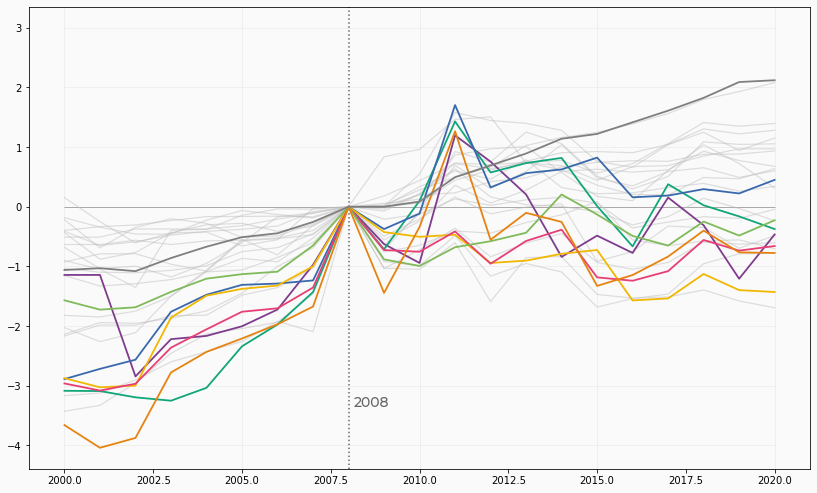

In [16]:
# Initialize layout ----------------------------------------------
fig, ax = plt.subplots(figsize = (14, 8.5))

# Background color
fig.patch.set_facecolor(GREY98)
ax.set_facecolor(GREY98)

# Vertical lines used as scale reference
for h in VLINES:
    ax.axvline(h, color=GREY91, lw=0.6, zorder=0)

# Horizontal lines
ax.hlines(y=np.arange(-4, 4), xmin=2000, xmax=2020, color=GREY91, lw=0.6)

# Darker horizontal line at y=0
ax.hlines(y=0, xmin=2000, xmax=2020, color=GREY60, lw=0.8)

# Vertical like at x = 2008
ax.axvline(2008, color=GREY40, ls="dotted")

# Annotations indicating the meaning of the vertical line
ax.text(2008.15, -3.35, "2008", fontname="Montserrat", 
        fontsize=14, fontweight=500, color=GREY40, ha="left")

# Add lines ------------------------------------------------------
# Create one data frame for the highlighted countries, and other
# for non-highlighted countries.
df_highlight = df_mac_indexed_2008[df_mac_indexed_2008["group"] != "other"]
df_others = df_mac_indexed_2008[df_mac_indexed_2008["group"] == "other"]

for group in df_others["iso_a3"].unique():
    data = df_others[df_others["iso_a3"] == group]
    ax.plot("year", "price_rel", c=GREY75, lw=1.2, alpha=0.5, data=data)

for idx, group in enumerate(df_highlight["iso_a3"].unique()):
    data = df_highlight[df_highlight["iso_a3"] == group]
    color = COLOR_SCALE[idx]
    ax.plot("year", "price_rel", color=color, lw=1.8, data=data)

That's a pretty good start! Having different colors for selected countries makes it much easier to see their price index evolution.

## Add labels

Although colors are a tremendous help, they don't reveal which country the lines represent. Wouldn't it be nice to have a label on the end of each line that tells which country it represents? Let's do it!

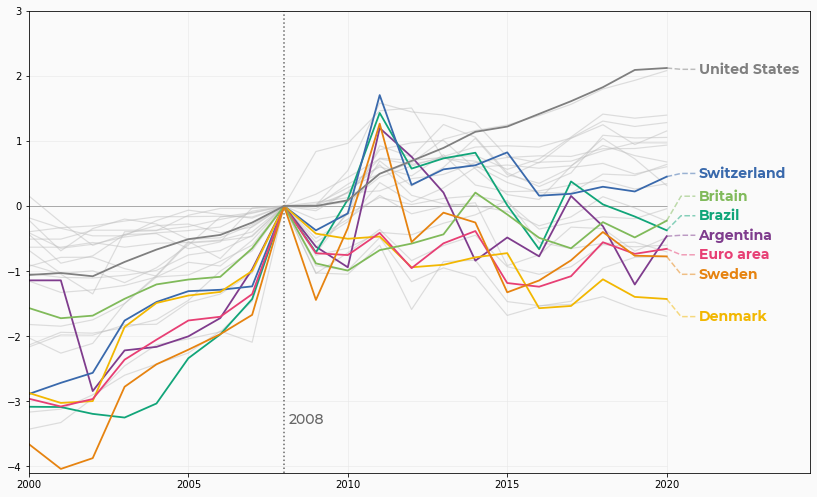

In [13]:
# First, adjust axes limits so annotations fit in the plot
ax.set_xlim(2000, 2024.5)
ax.set_ylim(-4.1, 3)

# Positions
LABEL_Y = [
    -0.45,  # ARG
    -0.15,  # BRA
    0.5,    # CHE
    -1.7,   # DNK
    -0.75,  # EUZ
    0.15,   # GBR
    -1.05,  # SWE
    2.1     # USA
]

x_start = 2020
x_end = 2021
PAD = 0.1

# Add labels for highlighted countries honly
for idx, group in enumerate(df_highlight["iso_a3"].unique()):
    data = df_highlight[(df_highlight["iso_a3"] == group) & (df_highlight["year"] == 2020)]
    color = COLOR_SCALE[idx]
    
    # Country name
    text = data["name"].values[0]
    
    # Vertical start of line
    y_start = data["price_rel"].values[0]
    # Vertical end of line
    y_end = LABEL_Y[idx]
    
    # Add line based on three points
    ax.plot(
        [x_start, (x_start + x_end - PAD) / 2 , x_end - PAD], 
        [y_start, y_end, y_end], 
        color=color, 
        alpha=0.5, 
        ls="dashed"
    )
    
    # Add country text
    ax.text(
        x_end, 
        y_end, 
        text, 
        color=color, 
        fontsize=14, 
        weight="bold", 
        fontfamily="Montserrat", 
        va="center"
    )
fig

Wonderful! It's amazing how a few annotations can hugely improve the readability of the plot.

## Final chart

The default layout of the chart above looks quite standard and boring. Some work is needed to make it look better. It's time to add a good title and some touches to the axes.

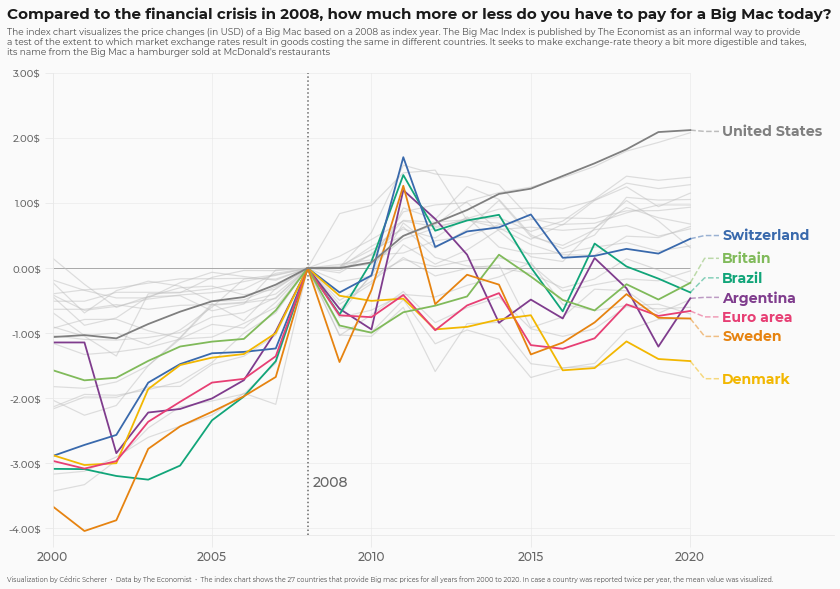

In [14]:
# Customize axes labels and ticks --------------------------------
ax.set_yticks([y for y in np.arange(-4, 4)])
ax.set_yticklabels(
    [f"{y}.00$" for y in np.arange(-4, 4)], 
    fontname="Montserrat", 
    fontsize=10,
    weight=500,
    color=GREY40
)

ax.set_xticks([x for x in np.arange(2000, 2025, 5)])
ax.set_xticklabels(
    [x for x in np.arange(2000, 2025, 5)], 
    fontname= "Montserrat", 
    fontsize=12,
    weight=500,
    color=GREY40
)

# Increase size and change color of axes ticks
ax.tick_params(axis="x", length=12, color=GREY91)
ax.tick_params(axis="y", length=8, color=GREY91)

# Customize spines
ax.spines["left"].set_color(GREY91)
ax.spines["bottom"].set_color(GREY91)
ax.spines["right"].set_color("none")
ax.spines["top"].set_color("none")

# Add titles, subtitles, and caption -----------------------------
# This uses `fig.text()` instead of regular titles to have full
# control of the text alignment.
subtitle = [
    "The index chart visualizes the price changes (in USD) of a Big Mac based on a 2008 as index year. The Big Mac Index is published by The Economist as an informal way to provide",
    "a test of the extent to which market exchange rates result in goods costing the same in different countries. It seeks to make exchange-rate theory a bit more digestible and takes,", 
    "its name from the Big Mac a hamburger sold at McDonald's restaurants", 
]

fig.text(
    0.08,
    0.97,
    "Compared to the financial crisis in 2008, how much more or less do you have to pay for a Big Mac today?",
    color=GREY10,
    fontsize=15,
    fontname="Montserrat",
    weight="bold"
)

fig.text(
    0.08,
    0.91,
    "\n".join(subtitle),
    ha="left",
    color=GREY30,
    fontname="Montserrat",
    fontsize=9,
)

fig.text(
    0.08, 
    0.05, 
    "Visualization by Cédric Scherer  •  Data by The Economist  •  The index chart shows the 27 countries that provide Big mac prices for all years from 2000 to 2020. In case a country was reported twice per year, the mean value was visualized.", 
    fontname="Montserrat", 
    fontsize=6.5, 
    color=GREY30, 
    ha="left"
)

fig